In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import re
import time
import warnings
import sqlite3
#from sqlalchemy import create_engine # database connection
import csv
import os
warnings.filterwarnings("ignore")
import datetime as dt
import numpy as np
from nltk.corpus import stopwords
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import normalize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.manifold import TSNE
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics.classification import accuracy_score, log_loss
from sklearn.feature_extraction.text import TfidfVectorizer
from collections import Counter
from scipy.sparse import hstack
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
#from sklearn.cross_validation import StratifiedKFold 
from collections import Counter, defaultdict
from sklearn.calibration import CalibratedClassifierCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
import math
from sklearn.metrics import normalized_mutual_info_score
from sklearn.ensemble import RandomForestClassifier



from sklearn.model_selection import cross_val_score
from sklearn.linear_model import SGDClassifier
from mlxtend.classifier import StackingClassifier

from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_recall_curve, auc, roc_curve

In [2]:
quora = pd.read_csv('nlp_features_train.csv', encoding='latin-1')

In [3]:
import nltk
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

[nltk_data] Error loading stopwords: <urlopen error [Errno 11001]
[nltk_data]     getaddrinfo failed>


In [4]:
quora['question1'] = quora['question1'].map(str)
quora['question2'] = quora['question2'].map(str)

In [5]:
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    phrase = re.sub(r"([0-9]+)000000", r"\1m", phrase)
    phrase = re.sub(r"([0-9]+)000", r"\1k", phrase)
    return phrase

In [6]:
from tqdm import tqdm
clean_question1 = []
# tqdm is for printing the status bar
for sentance in tqdm(quora['question1'].values):
    sent = decontracted(sentance)
    sent = sent.replace('\\r', ' ')
    sent = sent.replace('\\"', ' ')
    sent = sent.replace('\\n', ' ')
    sent = re.sub('[^A-Za-z0-9]+', ' ', sent)
    # https://gist.github.com/sebleier/554280
    sent = ' '.join(e for e in sent.split() if e.lower() not in stop_words)
    clean_question1.append(sent.lower().strip())

100%|███████████████████████████████| 404290/404290 [00:16<00:00, 24635.59it/s]


In [7]:
from tqdm import tqdm
clean_question2 = []
# tqdm is for printing the status bar
for sentance in tqdm(quora['question2'].values):
    sent = decontracted(sentance)
    sent = sent.replace('\\r', ' ')
    sent = sent.replace('\\"', ' ')
    sent = sent.replace('\\n', ' ')
    sent = re.sub('[^A-Za-z0-9]+', ' ', sent)
    # https://gist.github.com/sebleier/554280
    sent = ' '.join(e for e in sent.split() if e.lower() not in stop_words)
    clean_question2.append(sent.lower().strip())

100%|███████████████████████████████| 404290/404290 [00:16<00:00, 24051.94it/s]


In [8]:
quora['clean_question1'] = clean_question1
quora['clean_question2'] = clean_question2

In [9]:
quora_data = quora.sample(n=100000)
X = quora_data.drop(['is_duplicate'], axis=1)
Y = quora_data['is_duplicate']

In [10]:
from sklearn.model_selection import train_test_split
x_tr, x_test, y_tr, y_test = train_test_split(X, Y, test_size=0.3, shuffle=False)
print(x_tr.shape, y_tr.shape, x_test.shape, y_test.shape)

(70000, 22) (70000,) (30000, 22) (30000,)


In [11]:
from sklearn.preprocessing import StandardScaler
scaled_features_tr = x_tr.copy()
scaled_features_test = x_test.copy()
col_names = ['cwc_min', 'cwc_max', 'csc_min', 'csc_max' , 'ctc_min' , 'ctc_max' , 'last_word_eq', 'first_word_eq' , 'abs_len_diff' , 'mean_len' , 'token_set_ratio' , 'token_sort_ratio' ,  'fuzz_ratio' , 'fuzz_partial_ratio' , 'longest_substr_ratio']
features_tr = scaled_features_tr[col_names]
features_test = scaled_features_test[col_names]
scaler = StandardScaler().fit(features_tr.values)
x_tr_num = scaler.transform(features_tr.values)
x_test_num = scaler.transform(features_test.values)

In [12]:
from sklearn.feature_extraction.text import TfidfVectorizer
tf = TfidfVectorizer(ngram_range=(1,8))
x_tr_q1_tfidf = tf.fit_transform(x_tr['clean_question1'].values)
x_test_q1_tfidf = tf.transform(x_test['clean_question1'].values)

In [13]:
from sklearn.feature_extraction.text import TfidfVectorizer
tf = TfidfVectorizer(ngram_range=(1,8))
x_tr_q2_tfidf = tf.fit_transform(x_tr['clean_question2'].values)
x_test_q2_tfidf = tf.transform(x_test['clean_question2'].values)

In [14]:
from scipy.sparse import hstack
x_tr_tfidf = hstack((x_tr_q1_tfidf, x_tr_q2_tfidf, x_tr_num))
x_test_tfidf = hstack((x_test_q1_tfidf, x_test_q2_tfidf, x_test_num))

In [17]:
# This function plots the confusion matrices given y_i, y_i_hat.
def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    # C = 9,9 matrix, each cell (i,j) represents number of points of class i are predicted class j
    
    A =(((C.T)/(C.sum(axis=1))).T)
    #divid each element of the confusion matrix with the sum of elements in that column
    
    # C = [[1, 2],
    #     [3, 4]]
    # C.T = [[1, 3],
    #        [2, 4]]
    # C.sum(axis = 1)  axis=0 corresonds to columns and axis=1 corresponds to rows in two diamensional array
    # C.sum(axix =1) = [[3, 7]]
    # ((C.T)/(C.sum(axis=1))) = [[1/3, 3/7]
    #                           [2/3, 4/7]]

    # ((C.T)/(C.sum(axis=1))).T = [[1/3, 2/3]
    #                           [3/7, 4/7]]
    # sum of row elements = 1
    
    B =(C/C.sum(axis=0))
    #divid each element of the confusion matrix with the sum of elements in that row
    # C = [[1, 2],
    #     [3, 4]]
    # C.sum(axis = 0)  axis=0 corresonds to columns and axis=1 corresponds to rows in two diamensional array
    # C.sum(axix =0) = [[4, 6]]
    # (C/C.sum(axis=0)) = [[1/4, 2/6],
    #                      [3/4, 4/6]] 
    plt.figure(figsize=(20,4))
    
    labels = [0,1]
    # representing A in heatmap format
    cmap=sns.light_palette("blue")
    plt.subplot(1, 3, 1)
    sns.heatmap(C, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Confusion matrix")
    
    plt.subplot(1, 3, 2)
    sns.heatmap(B, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Precision matrix")
    
    plt.subplot(1, 3, 3)
    # representing B in heatmap format
    sns.heatmap(A, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Recall matrix")
    
    plt.show()

<h2> Building a random model (Finding worst-case log-loss) </h2>

Log loss on Test Data using Random Model 0.887242646958


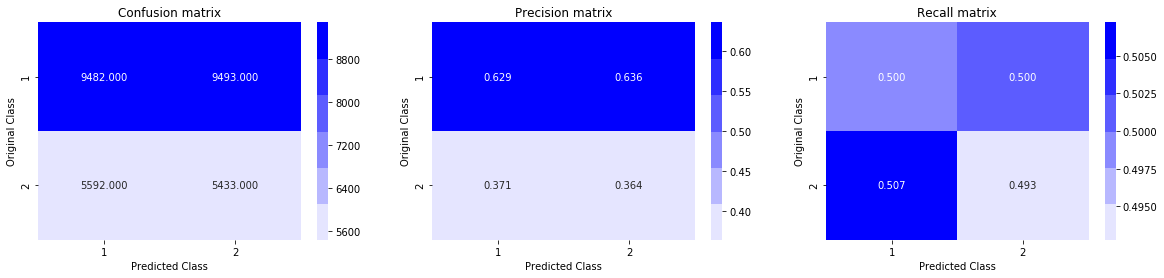

In [0]:
# we need to generate 9 numbers and the sum of numbers should be 1
# one solution is to genarate 9 numbers and divide each of the numbers by their sum
# ref: https://stackoverflow.com/a/18662466/4084039
# we create a output array that has exactly same size as the CV data
predicted_y = np.zeros((test_len,2))
for i in range(test_len):
    rand_probs = np.random.rand(1,2)
    predicted_y[i] = ((rand_probs/sum(sum(rand_probs)))[0])
print("Log loss on Test Data using Random Model",log_loss(y_test, predicted_y, eps=1e-15))

predicted_y =np.argmax(predicted_y, axis=1)
plot_confusion_matrix(y_test, predicted_y)

<h2> Logistic Regression TF-IDF features and hyperparameter tuning </h2>

For values of C =  0.0001 The log loss is: 0.5835525885144449
For values of C =  0.001 The log loss is: 0.5620200524067976
For values of C =  0.01 The log loss is: 0.542547396842715
For values of C =  0.1 The log loss is: 0.4923712947165579
For values of C =  1 The log loss is: 0.44412360730622563
For values of C =  10 The log loss is: 0.4567197785177261
For values of C =  100 The log loss is: 0.5632584507116463
The optimal C is  1


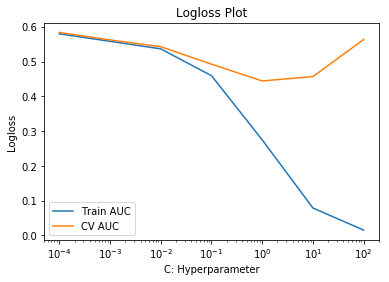

In [15]:
train_loss_tfidf = []
test_loss_tfidf = []
C = [0.0001, 0.001, 0.01, 0.1, 1, 10, 100]
for i in C :
         LR = LogisticRegression(C=i, class_weight='balanced', random_state=42)
         LR.fit(x_tr_tfidf, y_tr)
         y_train_pred = LR.predict_proba(x_tr_tfidf)[:,1]
         y_test_pred = LR.predict_proba(x_test_tfidf)[:,1]
         train_loss_tfidf.append(log_loss(y_tr, y_train_pred, eps=1e-15))
         test_loss_tfidf.append(log_loss(y_test, y_test_pred, eps=1e-15))
         print('For values of C = ', i, "The log loss is:",log_loss(y_test, y_test_pred, labels=LR.classes_, eps=1e-15))   
         
optimal_C_tfidf = C[test_loss_tfidf.index(min(test_loss_tfidf))]
print('The optimal C is ', optimal_C_tfidf)

plt.plot(C, train_loss_tfidf, label='Train AUC')
plt.plot(C, test_loss_tfidf, label='CV AUC')
plt.legend()
plt.xlabel('C: Hyperparameter')
plt.ylabel('Logloss')
plt.xscale('log')
plt.title('Logloss Plot')
plt.show()

For values of best alpha =  1 The train log loss is: 0.2747449267765691
For values of best alpha =  1 The test log loss is: 0.44412360730622563
Total number of data points : 30000


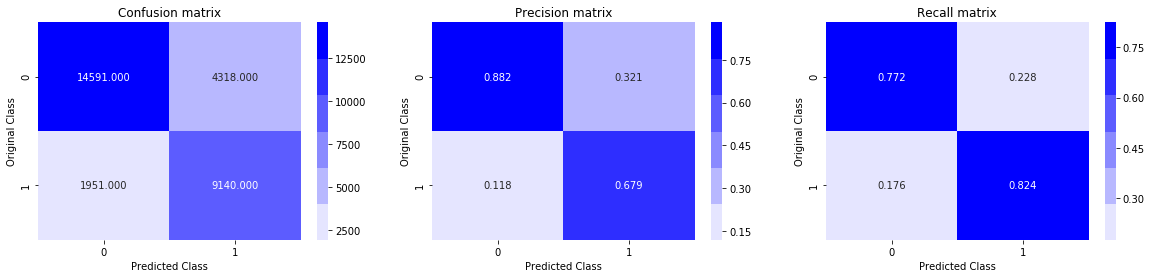

In [21]:
LR = LogisticRegression(C=optimal_C_tfidf, class_weight='balanced')
LR.fit(x_tr_tfidf, y_tr)

predict_y_tr = LR.predict_proba(x_tr_tfidf)
print('For values of best alpha = ', optimal_C_tfidf, "The train log loss is:",log_loss(y_tr, predict_y_tr, labels=LR.classes_, eps=1e-15))
predict_y_test = LR.predict_proba(x_test_tfidf)
print('For values of best alpha = ', optimal_C_tfidf, "The test log loss is:",log_loss(y_test, predict_y_test, labels=LR.classes_, eps=1e-15))
predicted_y =np.argmax(predict_y_test,axis=1)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(y_test, predicted_y)

<h2> Applying Linear SVM with TF-IDF features </h2>

For values of C =  1e-05 The log loss is: 0.5703330721769319
For values of C =  0.0001 The log loss is: 0.47596379861409444
For values of C =  0.001 The log loss is: 0.49553033837649096
For values of C =  0.01 The log loss is: 0.5300993886765378
For values of C =  0.1 The log loss is: 0.542891096910455
For values of C =  1 The log loss is: 0.5615783607982358
For values of C =  10 The log loss is: 0.5727933846576716
For values of C =  100 The log loss is: 0.5727802042439187
The optimal C is  0.0001


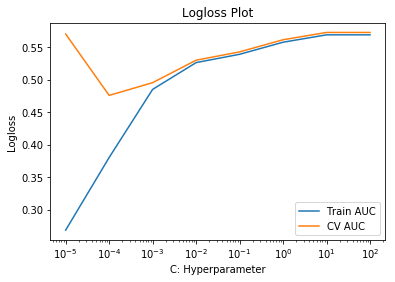

In [23]:
train_loss_tfidf_svm = []
test_loss_tfidf_svm = []
C = [0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100]
for i in C :
         lin_svm = SGDClassifier(alpha=i, class_weight='balanced', loss='hinge', random_state=42)
         lin_svm.fit(x_tr_tfidf, y_tr)
         svm = CalibratedClassifierCV(lin_svm, cv='prefit', method='sigmoid')
         svm.fit(x_tr_tfidf, y_tr)
         y_train_pred = svm.predict_proba(x_tr_tfidf)[:,1]
         y_test_pred = svm.predict_proba(x_test_tfidf)[:,1]
         train_loss_tfidf_svm.append(log_loss(y_tr, y_train_pred, eps=1e-15))
         test_loss_tfidf_svm.append(log_loss(y_test, y_test_pred, eps=1e-15))
         print('For values of C = ', i, "The log loss is:",log_loss(y_test, y_test_pred, labels=svm.classes_, eps=1e-15))   
         
optimal_C_tfidf_svm = C[test_loss_tfidf_svm.index(min(test_loss_tfidf_svm))]
print('The optimal C is ', optimal_C_tfidf_svm)

plt.plot(C, train_loss_tfidf_svm, label='Train AUC')
plt.plot(C, test_loss_tfidf_svm, label='CV AUC')
plt.legend()
plt.xlabel('C: Hyperparameter')
plt.ylabel('Logloss')
plt.xscale('log')
plt.title('Logloss Plot')
plt.show()

For values of best alpha =  0.0001 The train log loss is: 0.380419457081997
For values of best alpha =  0.0001 The test log loss is: 0.47596379861409444
Total number of data points : 30000


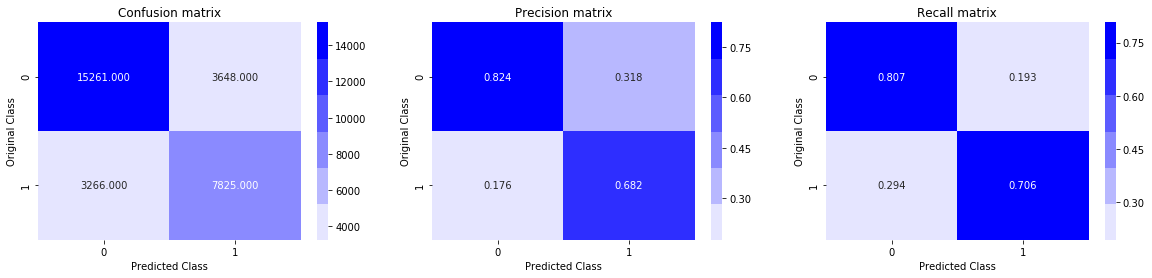

In [24]:
lin_svm = SGDClassifier(alpha=optimal_C_tfidf_svm, class_weight='balanced', loss='hinge', random_state=42)
lin_svm.fit(x_tr_tfidf, y_tr)
svm = CalibratedClassifierCV(lin_svm, cv='prefit', method='sigmoid')
svm.fit(x_tr_tfidf, y_tr)

predict_y_tr_svm = svm.predict_proba(x_tr_tfidf)
print('For values of best alpha = ', optimal_C_tfidf_svm, "The train log loss is:",log_loss(y_tr, predict_y_tr_svm, labels=svm.classes_, eps=1e-15))
predict_y_test_svm = svm.predict_proba(x_test_tfidf)
print('For values of best alpha = ', optimal_C_tfidf_svm, "The test log loss is:",log_loss(y_test, predict_y_test_svm, labels=svm.classes_, eps=1e-15))
predicted_y_svm =np.argmax(predict_y_test_svm,axis=1)
print("Total number of data points :", len(predicted_y_svm))
plot_confusion_matrix(y_test, predicted_y_svm)

<h2> Hyperparameter tune XgBoost with TF-IDF weighted W2V features using RandomSearch to reduce the log-loss. </h2>

In [25]:
# merge texts
questions = list(x_tr['question1']) + list(x_tr['question2'])

tfidf = TfidfVectorizer(lowercase=False)
tfidf.fit_transform(questions)

# dict key:word and value:tf-idf score
word2tfidf = dict(zip(tfidf.get_feature_names(), tfidf.idf_))

In [30]:
# en_vectors_web_lg, which includes over 1 million unique vectors.
import spacy
nlp = spacy.load('en_core_web_sm')

vecs1_tr = []
# https://github.com/noamraph/tqdm
# tqdm is used to print the progress bar
for qu1 in list(x_tr['question1']):
    doc1 = nlp(qu1) 
    # 384 is the number of dimensions of vectors 
    mean_vec1 = np.zeros([len(doc1), len(doc1[0].vector)])
    for word1 in doc1:
        # word2vec
        vec1 = word1.vector
        # fetch df score
        try:
            idf = word2tfidf[str(word1)]
        except:
            idf = 0
        # compute final vec
        mean_vec1 += vec1 * idf
    mean_vec1 = mean_vec1.mean(axis=0)
    vecs1_tr.append(mean_vec1)

x_tr_q1_tfw2v = np.array(vecs1_tr)

In [31]:
vecs1_test = []
# https://github.com/noamraph/tqdm
# tqdm is used to print the progress bar
for qu1 in list(x_test['question1']):
    doc1 = nlp(qu1) 
    # 384 is the number of dimensions of vectors 
    mean_vec1 = np.zeros([len(doc1), len(doc1[0].vector)])
    for word1 in doc1:
        # word2vec
        vec1 = word1.vector
        # fetch df score
        try:
            idf = word2tfidf[str(word1)]
        except:
            idf = 0
        # compute final vec
        mean_vec1 += vec1 * idf
    mean_vec1 = mean_vec1.mean(axis=0)
    vecs1_test.append(mean_vec1)

x_test_q1_tfw2v = np.array(vecs1_test)

In [33]:
vecs2_tr = []
# https://github.com/noamraph/tqdm
# tqdm is used to print the progress bar
for qu1 in list(x_tr['question2']):
    doc1 = nlp(qu1) 
    # 384 is the number of dimensions of vectors 
    mean_vec1 = np.zeros([len(doc1), len(doc1[0].vector)])
    for word1 in doc1:
        # word2vec
        vec1 = word1.vector
        # fetch df score
        try:
            idf = word2tfidf[str(word1)]
        except:
            idf = 0
        # compute final vec
        mean_vec1 += vec1 * idf
    mean_vec1 = mean_vec1.mean(axis=0)
    vecs2_tr.append(mean_vec1)

x_tr_q2_tfw2v = np.array(vecs2_tr)

In [34]:
vecs2_test = []
# https://github.com/noamraph/tqdm
# tqdm is used to print the progress bar
for qu1 in list(x_test['question2']):
    doc1 = nlp(qu1) 
    # 384 is the number of dimensions of vectors 
    mean_vec1 = np.zeros([len(doc1), len(doc1[0].vector)])
    for word1 in doc1:
        # word2vec
        vec1 = word1.vector
        # fetch df score
        try:
            idf = word2tfidf[str(word1)]
        except:
            idf = 0
        # compute final vec
        mean_vec1 += vec1 * idf
    mean_vec1 = mean_vec1.mean(axis=0)
    vecs2_test.append(mean_vec1)

x_test_q2_tfw2v = np.array(vecs2_test)

In [36]:
x_tr_tfw2v = np.hstack((x_tr_num, x_tr_q1_tfw2v, x_tr_q2_tfw2v))
x_test_tfw2v = np.hstack((x_test_num, x_test_q1_tfw2v, x_test_q2_tfw2v))

<h3> Applying Random Search to the XGBoost model </h3>

In [57]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import make_scorer
import xgboost as xgb
XGB = xgb.XGBClassifier()
parameters = {'n_estimators':[10,50,75,100,500,1000], 'max_depth':[2,3,5,10,20]}
rsXGB = RandomizedSearchCV(XGB, parameters, cv=3, scoring='neg_log_loss')
rsXGB.fit(x_tr_tfw2v, y_tr)

RandomizedSearchCV(cv=3, error_score='raise-deprecating',
          estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1),
          fit_params=None, iid='warn', n_iter=10, n_jobs=None,
          param_distributions={'n_estimators': [10, 50, 75, 100, 500, 1000], 'max_depth': [2, 3, 5, 10, 20]},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score='warn', scoring='neg_log_loss', verbose=0)

In [63]:
rsXGB.best_params_

{'n_estimators': 500, 'max_depth': 5}

The train log loss is: 0.2826742965175827
The test log loss is: 0.4181148340205307
Total number of data points : 30000


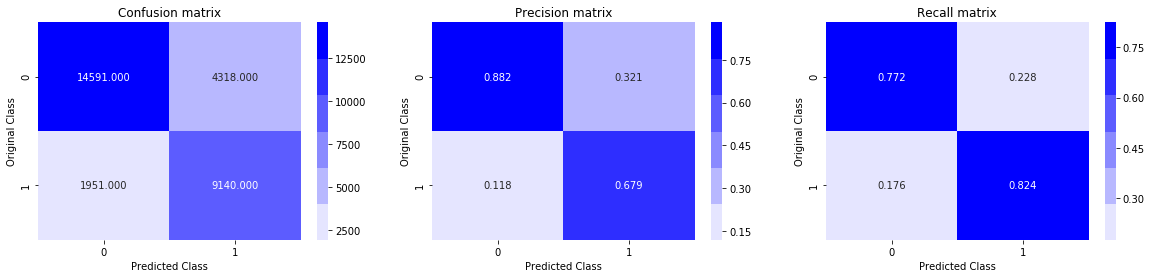

In [67]:
xgb_final = xgb.XGBClassifier(n_estimators=500, max_depth=5)
#xgb_final = LogisticRegression(C=1)
xgb_final.fit(x_tr_tfw2v, y_tr)

predict_y_tr_xgb = xgb_final.predict_proba(x_tr_tfw2v)
print("The train log loss is:",log_loss(y_tr, predict_y_tr_xgb, eps=1e-15))
predict_y_test_xgb = xgb_final.predict_proba(x_test_tfw2v)
print("The test log loss is:",log_loss(y_test, predict_y_test_xgb, eps=1e-15))
predicted_y_xgb = np.argmax(predict_y_test_xgb,axis=1)
print("Total number of data points :", len(predicted_y_xgb))
plot_confusion_matrix(y_test, predicted_y)

# Summary

**Logistic Regression model with TF-IDF features gave a TPR and TNR of 82% and 77% while the Linear SVM model with TF-IDF features gave TPR and TNR of 70% and 80%.**

**XGBoost model after hyperparameter tuning gave the best results and reduced the logloss from 0.45 to 0.41.**